This notebook will test the results of training models on in silico datasets generated with different custom mean adjustment funcitons. For example, we can observe the effects of training a model on a dataset where the datapoints' means were adjusted based on what other TFs were in the bound group for the gene.

In [2]:
from yeastdnnexplorer.probability_models.generate_data import (
    generate_gene_population,
    generate_binding_effects,
    generate_pvalues,
    perturbation_effect_adjustment_function_with_tf_relationships,
    generate_perturbation_effects,
)

import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices

Generating the gene populations and binding effects is the same as always (see the tutorial notebook on generating and using in silico data)

In [3]:
n_genes = 1000
signal = [0.1, 0.15, 0.2, 0.25, 0.3]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for signal_proportion, n_draws in zip(signal, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(
            generate_gene_population(n_genes, signal_proportion)
        )

# Generate binding data for each gene population
binding_effect_list = [
    generate_binding_effects(gene_population)
    for gene_population in gene_populations_list
]

# Calculate p-values for binding data
binding_pvalue_list = [
    generate_pvalues(binding_data) for binding_data in binding_effect_list
]

binding_data_combined = [
    torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
    for gene_population, binding_effect, binding_pval in zip(
        gene_populations_list, binding_effect_list, binding_pvalue_list
    )
]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

print("Shape of binding_data_tensor: ", binding_data_tensor.shape)

Shape of binding_data_tensor:  torch.Size([1000, 10, 3])


Now, when we generate perturbation effects, we can pass in a map of dependencies between the TFs. For a specific gene, we only adjust its mean based off of TFs where the [gene, TF] point is both in the signal group for that TF's gene population AND if all of the TFs it depends on are in the signal group for that gene population. Make sure that max_mean_adjustment > 0 so that the adjustment function is used by generate_perturbation_effects.

In [3]:
tf_relationships = {
    0: [2, 4, 7],
    1: [8],
    2: [3, 9],
    3: [1, 6],
    4: [5],
    5: [0, 2, 8],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [0, 3, 8],
}


perturbation_effects_list = [
    generate_perturbation_effects(
        binding_data_tensor,
        tf_index=tf_index,
        max_mean_adjustment=3.0,
        tf_relationships=tf_relationships,
        adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
    )
    for tf_index in range(sum(n_sample))
]

perturbation_pvalue_list = [
    generate_pvalues(perturbation_effects)
    for perturbation_effects in perturbation_effects_list
]

Data Assembly step is also the same as always (see the generate in silico data notebook)

In [5]:
# Convert lists to tensors if they are not already
perturbation_effects_tensor = torch.stack(perturbation_effects_list, dim=1)
perturbation_pvalues_tensor = torch.stack(perturbation_pvalue_list, dim=1)

# Ensure perturbation data is reshaped to match [n_genes, n_tfs]
# This step might need adjustment based on the actual shapes of your tensors.
perturbation_effects_tensor = perturbation_effects_tensor.unsqueeze(
    -1
)  # Adds an extra dimension for concatenation
perturbation_pvalues_tensor = perturbation_pvalues_tensor.unsqueeze(
    -1
)  # Adds an extra dimension for concatenation

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor = torch.cat(
    (binding_data_tensor, perturbation_effects_tensor, perturbation_pvalues_tensor),
    dim=2,
)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


Now we can show the difference in the data when we use one adjustment function versus others.

Shape of perturbation_effects_tensor_dep_adjust:  torch.Size([1000, 10, 1])
Signal vs noise for the fourth gene
[1. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
tf relationships
{0: [2, 4, 7], 1: [4], 2: [3, 9], 3: [4], 4: [7], 5: [0, 2, 8], 6: [4], 7: [9], 8: [9], 9: [0]}


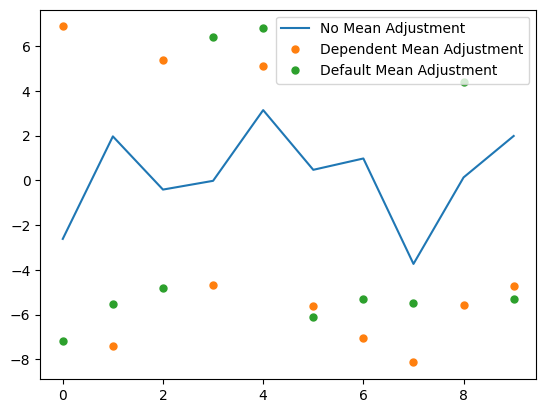

In [6]:
tf_relationships = {
    0: [2, 4, 7],
    1: [4],
    2: [3, 9],
    3: [4],
    4: [7],
    5: [0, 2, 8],
    6: [4],
    7: [9],
    8: [9],
    9: [0],
}

perturbation_effects_list_dependent_adjustment = [
    generate_perturbation_effects(
        binding_data_tensor,
        tf_index=tf_index,
        max_mean_adjustment=3.0,
        tf_relationships=tf_relationships,
        adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
    )
    for tf_index in range(sum(n_sample))
]

# Convert lists to tensors if they are not already
perturbation_effects_tensor_dep_adjust_tensor = torch.stack(
    perturbation_effects_list_dependent_adjustment, dim=1
)
perturbation_effects_tensor_dep_adjust = (
    perturbation_effects_tensor_dep_adjust_tensor.unsqueeze(-1)
)  # Adds an extra dimension for concatenation

perturbation_effects_list_default_adjustment = [
    generate_perturbation_effects(
        binding_data_tensor, tf_index=tf_index, max_mean_adjustment=3.0
    )
    for tf_index in range(sum(n_sample))
]

perturbation_effects_tensor_default_adjust_tensor = torch.stack(
    perturbation_effects_list_default_adjustment, dim=1
)
perturbation_effects_tensor_default_adjust = (
    perturbation_effects_tensor_default_adjust_tensor.unsqueeze(-1)
)  # Adds an extra dimension for concatenation

perturbation_effects_list_no_adjustment = [
    generate_perturbation_effects(
        binding_data_tensor, tf_index=tf_index, max_mean_adjustment=0.0
    )
    for tf_index in range(sum(n_sample))
]

perturbation_effects_tensor_no_adjustment_tensor = torch.stack(
    perturbation_effects_list_no_adjustment, dim=1
)
perturbation_effects_tensor_no_adjustment = (
    perturbation_effects_tensor_no_adjustment_tensor.unsqueeze(-1)
)  # Adds an extra dimension for concatenation

print(
    "Shape of perturbation_effects_tensor_dep_adjust: ",
    perturbation_effects_tensor_dep_adjust.shape,
)

print("Signal vs noise for the fourth gene")
print(binding_data_tensor[3, :, 0].numpy())

print("tf relationships")
print(tf_relationships)

# Plot the perturbation effects for the first gene (unadjusted, dependent adjustment, default adjustment)
plt.figure()
plt.plot(
    perturbation_effects_tensor_no_adjustment[3][:].numpy(), label="No Mean Adjustment"
)
plt.plot(
    perturbation_effects_tensor_dep_adjust[3][:].numpy(),
    ".",
    markersize=10,
    label="Dependent Mean Adjustment",
)
plt.plot(
    perturbation_effects_tensor_default_adjust[3][:].numpy(),
    ".",
    markersize=10,
    label="Default Mean Adjustment",
)
# plt.plot(perturbation_effects_tensor_default_adjust2[2][:].numpy(), '.', markersize=10, label="Default Mean Adjustment Double Check")
plt.xlabel("Transcription Factor Index")
plt.ylabel("Perturbation Effect")

plt.legend()
plt.show()

We define a small test function to study the results of generating data with only two TFs with different tf_relationship_dictionares passed in

In [16]:
def mini_dependent_adjustment_test(
    n_genes: int,
    signal: list[int],
    n_sample: list[int],
    tf_relationships_mini: dict[int, list[int]],
    max_mean_adjustment: float = 3.0,
):
    # this will be a list of length (num_tfs_) with a GenePopulation object in each element
    gene_populations_list = []
    for signal_proportion, n_draws in zip(signal, n_sample):
        for _ in range(n_draws):
            gene_populations_list.append(
                generate_gene_population(n_genes, signal_proportion)
            )

    # Generate binding data for each gene population
    binding_effect_list = [
        generate_binding_effects(gene_population)
        for gene_population in gene_populations_list
    ]

    # Calculate p-values for binding data
    binding_pvalue_list = [
        generate_pvalues(binding_data) for binding_data in binding_effect_list
    ]

    binding_data_combined = [
        torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
        for gene_population, binding_effect, binding_pval in zip(
            gene_populations_list, binding_effect_list, binding_pvalue_list
        )
    ]

    # Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
    binding_data_tensor = torch.stack(binding_data_combined, dim=1)

    print("Shape of binding_data_tensor: ", binding_data_tensor.shape)

    # Dependent mean adjustment (based on tf_relationships)
    mini_perturb_effects_list_dep_adjust = [
        generate_perturbation_effects(
            binding_data_tensor,
            tf_index=tf_index,
            max_mean_adjustment=max_mean_adjustment,
            tf_relationships=tf_relationships_mini,
            adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
        )
        for tf_index in range(sum(n_sample))
    ]
    mini_perturb_effects_tensor_dep_adjust = torch.stack(
        mini_perturb_effects_list_dep_adjust, dim=1
    )
    mini_perturb_effects_tensor_dep_adjust = (
        mini_perturb_effects_tensor_dep_adjust.unsqueeze(-1)
    )  # Adds an extra dimension for concatenation
    mini_perturb_effects_tensor_dep_adjust = abs(mini_perturb_effects_tensor_dep_adjust)

    # Default mean adjustment
    mini_perturb_effects_list_default_adjust = [
        generate_perturbation_effects(
            binding_data_tensor,
            tf_index=tf_index,
            max_mean_adjustment=max_mean_adjustment,
        )
        for tf_index in range(sum(n_sample))
    ]
    mini_perturb_effects_tensor_default_adjust = torch.stack(
        mini_perturb_effects_list_default_adjust, dim=1
    )
    mini_perturb_effects_tensor_default_adjust = (
        mini_perturb_effects_tensor_default_adjust.unsqueeze(-1)
    )
    mini_perturb_effects_tensor_default_adjust = abs(mini_perturb_effects_tensor_default_adjust)

    # No mean adjustment
    mini_perturb_effects_list_no_adjust = [
        generate_perturbation_effects(
            binding_data_tensor, tf_index=tf_index, max_mean_adjustment=0.0
        )
        for tf_index in range(sum(n_sample))
    ]
    mini_perturb_effects_tensor_no_adjust = torch.stack(
        mini_perturb_effects_list_no_adjust, dim=1
    )
    mini_perturb_effects_tensor_no_adjust = (
        mini_perturb_effects_tensor_no_adjust.unsqueeze(-1)
    )
    mini_perturb_effects_tensor_no_adjust = abs(mini_perturb_effects_tensor_no_adjust)

    GENE_IDX = 0

    # printing signal / noise to see what results should be
    print(f"Signal (1) vs noise (0) for the gene we're studying (index: {GENE_IDX})")
    print(binding_data_tensor[GENE_IDX, :, 0].numpy())

    # Plot the perturbation effects for the first gene (unadjusted, dependent adjustment, default adjustment)
    plt.figure()
    plt.plot(
        mini_perturb_effects_tensor_no_adjust[GENE_IDX][:].numpy(),
        ".",
        markersize=10,
        label="No Mean Adjustment",
    )
    plt.plot(
        mini_perturb_effects_tensor_dep_adjust[GENE_IDX][:].numpy(),
        ".",
        markersize=10,
        label="Dependent Mean Adjustment",
    )
    plt.plot(
        mini_perturb_effects_tensor_default_adjust[GENE_IDX][:].numpy(),
        ".",
        markersize=10,
        label="Default Mean Adjustment",
    )

    plt.xlabel("Transcription Factor Index")
    plt.ylabel("Perturbation Effect")

    num_tfs = sum(n_sample)
    plt.xticks(np.arange(0, num_tfs, 1))

    plt.legend()
    plt.show()

Shape of binding_data_tensor:  torch.Size([3, 2, 3])
Signal (1) vs noise (0) for the gene we're studying (index: 0)
[1. 1.]


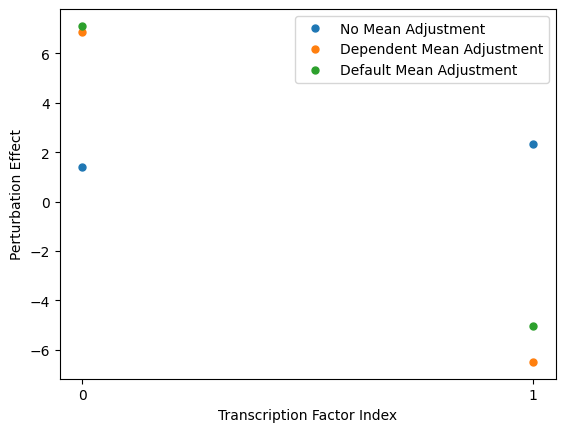

In [15]:
n_genes = 3
signal = [1, 1]  # making this high for testing purposes
n_sample = [1, 1]
tf_relationships_mini = {0: [1], 1: [0]}

mini_dependent_adjustment_test(n_genes, signal, n_sample, tf_relationships_mini)

Shape of binding_data_tensor:  torch.Size([3, 2, 3])
Signal (1) vs noise (0) for the gene we're studying (index: 0)
[1. 0.]


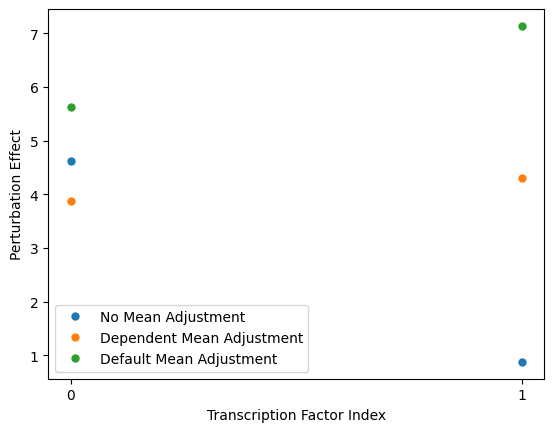

In [19]:
n_genes = 3
signal = [.5, .5]  # making this high for testing purposes
n_sample = [1, 1]
tf_relationships_mini = {0: [1], 1: []}

mini_dependent_adjustment_test(n_genes, signal, n_sample, tf_relationships_mini)

Shape of binding_data_tensor:  torch.Size([3, 2, 3])
Signal (1) vs noise (0) for the gene we're studying (index: 0)
[1. 1.]


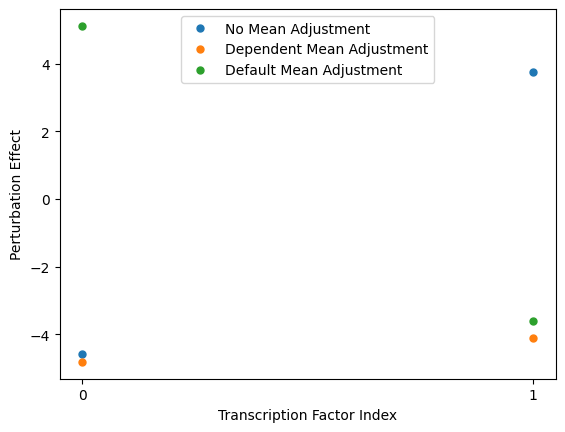

In [29]:
n_genes = 3
signal = [1, 1]  # making this high for testing purposes
n_sample = [1, 1]
# no dependencies (so should behave like the default adjustment function)
tf_relationships_mini = {0: [], 1: []}

mini_dependent_adjustment_test(n_genes, signal, n_sample, tf_relationships_mini)